In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

# **Sentinel-2 WOFS Product Creation**

### Config

Import required DC utils

In [2]:
import datacube
# DC utilities
#from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

#SAC utilities
from utils_sac.clean_mask import landsat_qa_clean_mask
from utils_sac.interactive_maps import display_map

Define aoi via wkt polygon (could be subbed or shapefile)

In [3]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
aoi_wkt = "POLYGON((178.11035156251 -17.841796875, 178.83544921876 -17.830810546875, 178.83544921876 -18.297729492187, 178.10485839844 -18.30322265625, 178.11035156251 -17.841796875))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')


In [4]:
dc = datacube.Datacube(app="na")

In [5]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [6]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.30322265625, -17.830810546875) 
Lon: (178.10485839844, 178.83544921876)


In [7]:
display_map(latitude = lat_extents, longitude = lon_extents)

### Load Data

Generic query specs

In [8]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,5,1), datetime(2019,5,1)),
                resolution = (90,90))

Dataset-specifics

In [9]:
scenes = dc.load(product="s2_esa_sr_granule",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"],
               **query)

In [10]:
scenes['swir1']=scenes.swir_1
scenes['swir2']=scenes.swir_2
scenes = scenes.drop('swir_1')
scenes = scenes.drop('swir_2')

In [11]:
scenes

<xarray.Dataset>
Dimensions:               (time: 125, x: 865, y: 588)
Coordinates:
  * time                  (time) datetime64[ns] 2018-08-25T22:29:59 ... 2019-04-29T22:19:49
  * y                     (y) float64 7.975e+06 7.975e+06 ... 8.028e+06
  * x                     (x) float64 6.167e+05 6.168e+05 ... 6.945e+05
Data variables:
    green                 (time, y, x) uint16 0 0 0 0 0 ... 1977 1846 1736 1735
    red                   (time, y, x) uint16 0 0 0 0 0 ... 1759 1630 1570 1604
    blue                  (time, y, x) uint16 0 0 0 0 0 ... 2252 2114 1958 1927
    nir                   (time, y, x) uint16 0 0 0 0 0 ... 1768 1646 1514 1491
    coastal_aerosol       (time, y, x) uint16 0 0 0 0 0 ... 1799 1755 2053 2026
    scene_classification  (time, y, x) uint8 0 0 0 0 0 0 0 0 ... 8 8 8 8 10 9 9
    swir1                 (time, y, x) uint16 0 0 0 0 0 ... 5349 5379 6743 6877
    swir2                 (time, y, x) uint16 0 0 0 0 0 ... 1616 1393 1411 1401
Attributes:
    crs:    

Check loaded

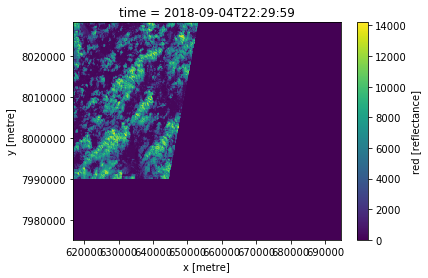

In [12]:
scenes.isel(time = 4).red.plot();

Create + apply 'cleansky' mask

8


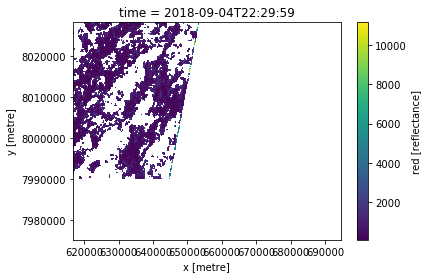

In [13]:
print(len(scenes))
clearsky_masks = landsat_qa_clean_mask(scenes, 'SENTINEL_2')
clearsky_scenes = scenes.where(clearsky_masks)
clearsky_scenes.isel(time = 4).red.plot();

Apply wofs classification

In [14]:
water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values, no_data = np.nan, x_coord='x', y_coord = "y")

Visualise wofs summary product

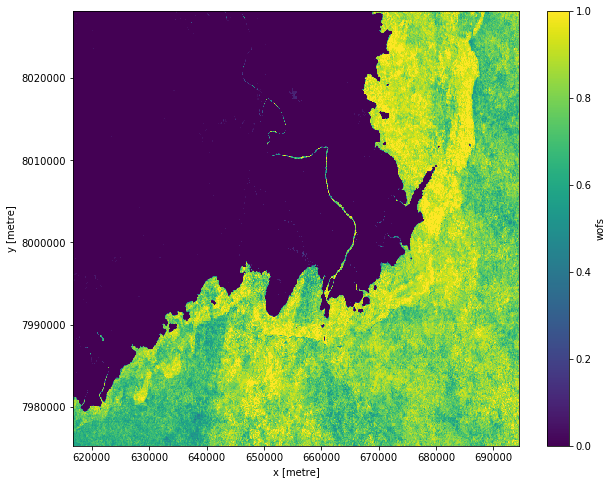

In [15]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()

### Export to File with Shared Storage

Define output path

In [16]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/s2_wofs_product_VL.nc"

In [17]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [18]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

In [19]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [20]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)
#export_xarray_to_netcdf